# Lesson 2 : LangGraph Components

In [29]:
from dotenv import load_dotenv
_ = load_dotenv()

In [30]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [31]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [32]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [33]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [34]:
prompt = """
You are an intelligent and efficient research assistant integrated with a web search tool (TavilySearchResults).
Your goal is to find accurate, up-to-date information to answer complex, multi-step user queries.

Guidelines:
1. You can use the search tool to find information on the internet.
2. You are allowed to make multiple calls, either simultaneously or sequentially.
3. Do not hallucinate. If uncertain, search first before answering.
4. Always explain your reasoning if the question requires multiple steps.
5. Be concise, factual, and structured in your answers.

Output Format:
- First, clearly state the answer.
- Then briefly explain how you found it (if needed).
- Cite the source if available from the tool result.

Example:
Q: Who won the Super Bowl in 2024, and what is the GDP of the winner’s home state?

A:
1. The Kansas City Chiefs won the Super Bowl in 2024.
2. Their home state is Missouri.
3. The GDP of Missouri is approximately $390 billion (as of 2023).

(Source: https://forum.wordreference.com/threads/write-a-summary-of-for-about-the-article.2648659/)
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

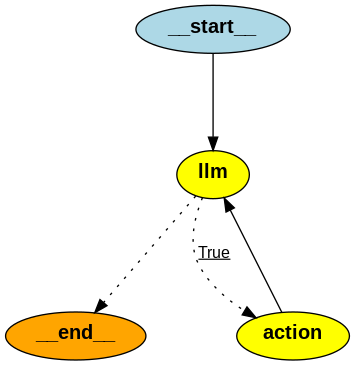

In [35]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [36]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_6WAUHhMczfR6cBjfwUOH2qzT'}
Back to the model!


In [37]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6WAUHhMczfR6cBjfwUOH2qzT', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 332, 'total_tokens': 354, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-519e8bb2-71a4-42f0-a1cc-d30e6823af8b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_6WAUHhMczfR6cBjfwUOH2qzT'}]),
  ToolMessage(content='[{\'url\': \'https://www.spreaker.com/episode/today-s-weather-

In [38]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a high of 68°F and a low of 56°F. Winds are expected to be from the WSW at 15 to 25 mph.\n\nSources:\n1. [Weather.com](https://weather.com/weather/tenday/l/San+Francisco+CA+USCA0987:1:US)'

In [39]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_sjYYzlEKj3E6j5MuGr9baW11'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_jr2UEfCpCu0MkWHDgPUQp5QT'}
Back to the model!


In [40]:
result['messages'][-1].content

'1. The current weather in San Francisco is partly cloudy with a low of 56°F and a high of 68°F. The wind is from the WSW at 10 to 20 mph.\n2. The current weather in Los Angeles is partly cloudy with a low of 63°F. Winds are light and variable.\n\nI found this information by searching for the current weather in San Francisco and Los Angeles using multiple sources like weather websites and forecasts.'

In [41]:
# A new, complex query to leverage the detailed prompt.
# This requires the agent to find a capital, then a person, then a population number.
query = """What is the capital of Australia? Who is the current prime minister of that country, and what is the approximate population of the capital city? Answer each question clearly."""
messages = [HumanMessage(content=query)]

# Use a more advanced model for complex, multi-step reasoning
model = ChatOpenAI(model="gpt-4o")
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Capital of Australia'}, 'id': 'call_3qElRCr8uM7gh7w50kDQg4TY'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Current Prime Minister of Australia 2023'}, 'id': 'call_y6TxunEyOXfIFo0LbxxFFDSf'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Population of Canberra 2023'}, 'id': 'call_CYUMxYz0T1lrk1tn58mpVm8l'}
Back to the model!


In [42]:
print(result['messages'][-1].content)

1. **Capital of Australia**: The capital city of Australia is Canberra. (Source: [Wikipedia](https://en.wikipedia.org/wiki/Canberra))

2. **Current Prime Minister of Australia**: The current Prime Minister of Australia is Anthony Albanese, who has been serving since May 23, 2022. (Source: [Wikipedia](https://en.wikipedia.org/wiki/Anthony_Albanese))

3. **Approximate Population of Canberra**: As of 2024, the estimated population of Canberra is approximately 473,855. (Source: [Australian Bureau of Statistics](https://www.abs.gov.au))
